In [128]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from yahoo_fin import options
from yahoo_fin import stock_info as si
from scipy import stats
from scipy.stats import norm
import sympy as sy
from sympy.stats import Normal, cdf

from tqdm import tqdm_notebook as tqdm

In [2]:
nflx_dates = options.get_expiration_dates("nflx")

In [3]:
nflx_dates

['May 1, 2020',
 'May 8, 2020',
 'May 15, 2020',
 'May 22, 2020',
 'May 29, 2020',
 'June 5, 2020',
 'June 19, 2020',
 'July 17, 2020',
 'August 21, 2020',
 'September 18, 2020',
 'November 20, 2020',
 'December 18, 2020',
 'January 15, 2021',
 'June 18, 2021',
 'January 21, 2022',
 'June 17, 2022']

In [6]:
call_nflx=options.get_calls("nflx")

In [8]:
call_nflx

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,NFLX200501C00155000,2020-04-24 10:28AM EDT,155.0,267.75,0.0,0.0,0.0,-,4,0,0.00%
1,NFLX200501C00165000,2020-04-23 12:56PM EDT,165.0,266.40,0.0,0.0,0.0,-,-,0,0.00%
2,NFLX200501C00170000,2020-04-24 9:48AM EDT,170.0,247.60,0.0,0.0,0.0,-,1,0,0.00%
3,NFLX200501C00175000,2020-04-20 2:23PM EDT,175.0,263.25,0.0,0.0,0.0,-,-,0,0.00%
4,NFLX200501C00190000,2020-04-23 12:36PM EDT,190.0,242.50,0.0,0.0,0.0,-,-,0,0.00%
...,...,...,...,...,...,...,...,...,...,...,...
84,NFLX200501C00610000,2020-04-24 12:03PM EDT,610.0,0.02,0.0,0.0,0.0,-,8,0,50.00%
85,NFLX200501C00620000,2020-04-24 11:15AM EDT,620.0,0.07,0.0,0.0,0.0,-,13,0,50.00%
86,NFLX200501C00630000,2020-04-24 10:40AM EDT,630.0,0.07,0.0,0.0,0.0,-,3,0,50.00%
87,NFLX200501C00640000,2020-04-24 3:23PM EDT,640.0,0.05,0.0,0.0,0.0,-,5,0,50.00%


In [10]:
dow_tickers = si.tickers_dow()

In [16]:
dow_tickers

['AAPL',
 'AXP',
 'BA',
 'CAT',
 'CSCO',
 'CVX',
 'DIS',
 'DOW',
 'GS',
 'HD',
 'IBM',
 'INTC',
 'JNJ',
 'JPM',
 'KO',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'PFE',
 'PG',
 'RTX',
 'TRV',
 'UNH',
 'V',
 'VZ',
 'WBA',
 'WMT',
 'XOM']

In [14]:
dow_data = {}
for ticker in dow_tickers:
    try:
        dow_data[ticker] = options.get_calls(ticker)
    except Exception:
        print(ticker + " failed")


RTX failed


In [24]:
list=[]
for i in dow_tickers:
    try:
        list.append(dow_data[i].shape[0])
    except Exception:
        print("Can't append ", i)
    

Can't append  RTX


In [29]:
list

[68,
 54,
 96,
 51,
 33,
 60,
 61,
 34,
 49,
 51,
 50,
 42,
 52,
 54,
 37,
 40,
 47,
 41,
 53,
 51,
 33,
 42,
 11,
 60,
 47,
 20,
 35,
 49,
 47]

In [96]:
def call_price(
        asset_price, strike_price, time_to_expiration
        , risk_free_rate, asset_volatility
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z1 = z1*asset_price
        x2 = math.log(asset_price/(b*strike_price)) - .5*(asset_volatility*asset_volatility)*time_to_expiration
        x2 = x2/(asset_volatility*(time_to_expiration**.5))
        z2 = norm.cdf(x2)
        z2 = b*strike_price*z2
        return z1 - z2

In [97]:
def euro_vanilla_call(S, K, T, r, sigma):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    call = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
    
    return call

In [172]:
#S0=100 K=100 T=1 r=0.05 sigma=0.2
p1=call_price(1000,100,200/365,0.05,0.2)
p1

902.702535943346

In [99]:
p2=euro_vanilla_call(100,100,1,0.05,0.2)
p2

10.450583572185565

In [102]:
def stockpath(current_asset_price,drift,asset_volatility,delta_t,n_steps):
        # Brownian motion is ~N(0,1)
        asset_prices=[]
        for i in range(n_steps):
            nor = np.random.normal()
            dS = drift*current_asset_price*delta_t + asset_volatility*current_asset_price*nor*math.sqrt(delta_t) 
            asset_prices.append(current_asset_price + dS)
            current_asset_price = current_asset_price + dS

        return np.asarray(asset_prices)
     

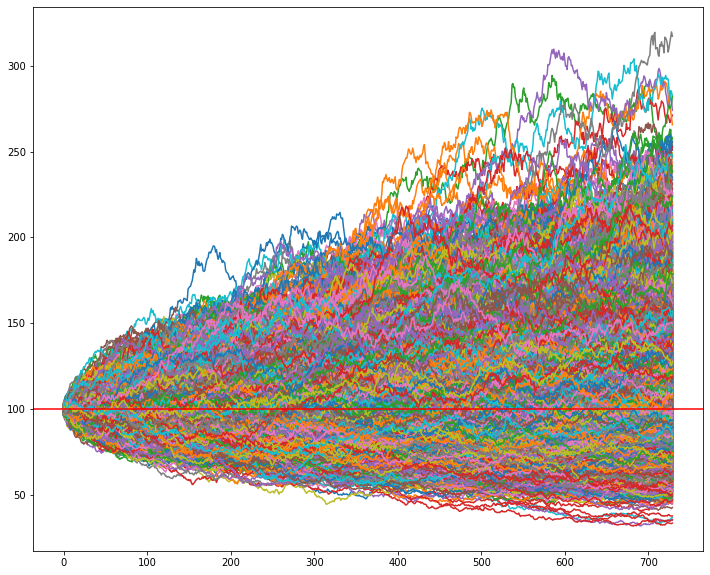

In [118]:
n_simulations=10000
n_steps=365*2
delta_t=1/365
data_array=np.zeros((n_simulations, n_steps))
S0=100
r=0.05 
sigma=0.2
plt.figure(figsize=(12 ,10))

for i in range(n_simulations):
    data_array[i,:]=stockpath(S0,r,sigma,delta_t,n_steps)
    plt.plot(range(n_steps),data_array[i,:])

plt.axhline(S0, 0, 1, label='S0',color='r')


Text(0, 0.5, 'Stock price')

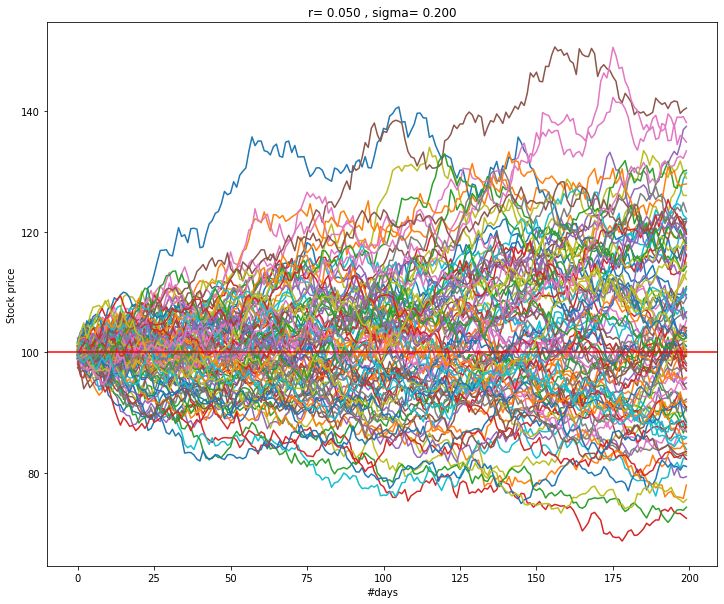

In [257]:
n_simulations=100
n_steps=200
delta_t=1/365
data_array4=np.zeros((n_simulations, n_steps))
S0=100
r=0.05
sigma=0.2
plt.figure(figsize=(12 ,10))

for i in tqdm(range(n_simulations)):
    data_array4[i,:]=stockpath(S0,r,sigma,delta_t,n_steps)
    plt.plot(range(n_steps),data_array4[i,:])

plt.axhline(S0, 0, 1, label='S0',color='r')
plt.title('r= %0.3f , sigma= %0.3f' %(r,sigma))
plt.xlabel('#days')
plt.ylabel('Stock price')


In [194]:
risk_array=np.linspace(0.01,0.1,num=10)
print(risk_array)

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]


In [347]:
check=make_data_array(0.05,0.2)

In [247]:
sigma_array=np.asarray([0.05,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.3,0.325,0.35,0.4,0.45,0.5,0.6])
len(sigma_array)

15

In [340]:
rs_pairs = [(r, sigma) for r in risk_array for sigma in sigma_array] 
print(rs_pairs[0])

(0.01, 0.05)


In [349]:
strike_prices=np.asarray([60,70,80,90,100,110,120,130,140,150])

In [354]:
def make_data_array(r=0.05,sigma=0.2):
    n_simulations=100
    n_steps=200
    delta_t=1/365
    data_array=np.zeros((n_simulations, n_steps))
    S0=100
    for i in range(n_simulations):
        data_array[i,:]=stockpath(S0,r,sigma,delta_t,n_steps)
    return data_array
    


In [355]:
data_array_list=[]
for i in range(len(rs_pairs)):
    r, sigma = rs_pairs[i]
    data_array_list.append(make_data_array(r, sigma) )
    print(i,end="\r")

In [361]:
data_array_list[0].shape

(100, 200)

In [316]:
t_list=[]
indexs=[]
for i in range(200):
    if i%4==0: #for 200 path lenght, 200/4=50
        t_list.append(210/365-i/365)  #expiration time
        indexs.append(i)
t50=np.asarray(t_list)

In [330]:
def col_stockpath(stockpath_row): 
    return np.column_stack((stockpath_row[indexs],np.asarray(t50)))
        

def col_data_array(data_array):  #makes two columns [stock | time]
    n_rows, n_cols=data_array.shape
    col_list=[]
    for i in range(n_rows):
        col_list.append(col_stockpath(data_array[i,:]))
    
    return np.vstack(col_list) 

In [329]:
a = np.array([[1, 2, 3, 4]])
b = np.array([[5, 6,7,8]])
t=210/365-np.ones(data_array4.shape[0])*1/365
lav=np.column_stack((data_array4[:,0], t))
lav2=np.column_stack((data_array4[:,0], t))
listl=[lav,lav2,lav]
conc=np.vstack(listl)
conc.shape

(300, 2)

In [376]:
d4=col_data_array(data_array_list[0])
see=np.c_[d4,np.ones(d4.shape[0])*0.2, np.ones(d4.shape[0])*0.05]
see

array([[9.99529680e+01, 5.75342466e-01, 2.00000000e-01, 5.00000000e-02],
       [9.99314298e+01, 5.64383562e-01, 2.00000000e-01, 5.00000000e-02],
       [9.93063050e+01, 5.53424658e-01, 2.00000000e-01, 5.00000000e-02],
       ...,
       [1.03011085e+02, 6.02739726e-02, 2.00000000e-01, 5.00000000e-02],
       [1.02521012e+02, 4.93150685e-02, 2.00000000e-01, 5.00000000e-02],
       [1.02184270e+02, 3.83561644e-02, 2.00000000e-01, 5.00000000e-02]])

In [387]:
def stackrsigma(r, sigma, data_col): # takes input two columns [stock | time] and adds columns of r and sigma
    n_rows=data_col.shape[0]
    return np.c_[data_col,np.ones(n_rows)*r, np.ones(n_rows)*sigma]
    

In [390]:
col_data_array_list=[] #list of data_array arrange in 4 columns
for i in range(len(data_array_list)):
    cols2=col_data_array(data_array_list[i])
    r, sigma= rs_pairs[i]
    col_data_array_list.append(stackrsigma(r, sigma, cols2))

In [442]:
col_data_array_list[0]

array([[9.99529680e+01, 5.75342466e-01, 1.00000000e-02, 5.00000000e-02],
       [9.99314298e+01, 5.64383562e-01, 1.00000000e-02, 5.00000000e-02],
       [9.93063050e+01, 5.53424658e-01, 1.00000000e-02, 5.00000000e-02],
       ...,
       [1.03011085e+02, 6.02739726e-02, 1.00000000e-02, 5.00000000e-02],
       [1.02521012e+02, 4.93150685e-02, 1.00000000e-02, 5.00000000e-02],
       [1.02184270e+02, 3.83561644e-02, 1.00000000e-02, 5.00000000e-02]])

In [439]:
vt=np.vstack(col_data_array_list) # [ Stock | time | r | sigma]

In [440]:
data_strikes_list=[]
for s in strike_prices:
    data_strikes_list.append( np.c_[vt, np.ones(vt.shape[0])*s ]  )

In [460]:
vt_strikes=np.vstack(data_strikes_list) # [ Stock | time | r | sigma | Strike]

In [461]:
time2=vt_strikes[:,1]+1
vt_strikes2=vt_strikes.copy()
vt_strikes2[:,1]=time2

In [462]:
vt_strikes

array([[9.99529680e+01, 5.75342466e-01, 1.00000000e-02, 5.00000000e-02,
        6.00000000e+01],
       [9.99314298e+01, 5.64383562e-01, 1.00000000e-02, 5.00000000e-02,
        6.00000000e+01],
       [9.93063050e+01, 5.53424658e-01, 1.00000000e-02, 5.00000000e-02,
        6.00000000e+01],
       ...,
       [1.13803702e+02, 6.02739726e-02, 1.00000000e-01, 6.00000000e-01,
        1.50000000e+02],
       [1.15919463e+02, 4.93150685e-02, 1.00000000e-01, 6.00000000e-01,
        1.50000000e+02],
       [1.19492642e+02, 3.83561644e-02, 1.00000000e-01, 6.00000000e-01,
        1.50000000e+02]])

In [463]:
vt_strikes2

array([[9.99529680e+01, 1.57534247e+00, 1.00000000e-02, 5.00000000e-02,
        6.00000000e+01],
       [9.99314298e+01, 1.56438356e+00, 1.00000000e-02, 5.00000000e-02,
        6.00000000e+01],
       [9.93063050e+01, 1.55342466e+00, 1.00000000e-02, 5.00000000e-02,
        6.00000000e+01],
       ...,
       [1.13803702e+02, 1.06027397e+00, 1.00000000e-01, 6.00000000e-01,
        1.50000000e+02],
       [1.15919463e+02, 1.04931507e+00, 1.00000000e-01, 6.00000000e-01,
        1.50000000e+02],
       [1.19492642e+02, 1.03835616e+00, 1.00000000e-01, 6.00000000e-01,
        1.50000000e+02]])

In [466]:
vdata=np.vstack([vt_strikes, vt_strikes2]) #15million X 5 #[ Stock | time | r | sigma | Strike]

In [467]:
vdata[:,[1, 4]] = vdata[:,[4, 1]]
vdata #[ Stock | Strike | r | sigma | time]

array([[9.99529680e+01, 6.00000000e+01, 1.00000000e-02, 5.00000000e-02,
        5.75342466e-01],
       [9.99314298e+01, 6.00000000e+01, 1.00000000e-02, 5.00000000e-02,
        5.64383562e-01],
       [9.93063050e+01, 6.00000000e+01, 1.00000000e-02, 5.00000000e-02,
        5.53424658e-01],
       ...,
       [1.13803702e+02, 1.50000000e+02, 1.00000000e-01, 6.00000000e-01,
        1.06027397e+00],
       [1.15919463e+02, 1.50000000e+02, 1.00000000e-01, 6.00000000e-01,
        1.04931507e+00],
       [1.19492642e+02, 1.50000000e+02, 1.00000000e-01, 6.00000000e-01,
        1.03835616e+00]])

In [471]:
callprice_list=[]
for i in tqdm(range(vdata.shape[0])):
    #print(i/vdata.shape[0],end="\r")
    asset_price=vdata[i,0]
    strike_price=vdata[i,1]
    time_to_expiration=vdata[i,4]
    risk_free_rate=vdata[i,2]
    asset_volatility=vdata[i,3]
    callprice_list.append(call_price(asset_price, strike_price, time_to_expiration, risk_free_rate, asset_volatility))

In [474]:
callprices=np.asarray(callprice_list)

15000000

In [475]:
finaldata=np.c_[vdata, callprices]

In [480]:
finaldata.shape

(15000000, 6)

In [479]:
np.savetxt('dataoptions.csv', finaldata, delimiter=',')